In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [2]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.ResNet50V2(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'ResNet50V2.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint


In [6]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [7]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [8]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - ResNet50V2.h5")
    print("Model Saved!")

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [10]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [11]:
mpath = r'../input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

for i in classPaths:
    className = i
    print(className)
    

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.


2022-05-14 17:50:25.609346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 17:50:25.722317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 17:50:25.723103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 17:50:25.725670: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil


For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']


2022-05-14 17:50:33.393852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Image Shape :  (32, 256, 256, 3)
94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]              

2022-05-14 17:50:41.864722: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


625/625 [==============================] - 195s 297ms/step - loss: 230.1431 - accuracy: 0.6353 - val_loss: 174.2060 - val_accuracy: 0.7196

Epoch 00001: val_loss improved from inf to 174.20599, saving model to Brain CancerResNet50V2.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
625/625 [==============================] - 129s 206ms/step - loss: 132.7340 - accuracy: 0.7517 - val_loss: 248.8408 - val_accuracy: 0.6556

Epoch 00002: val_loss did not improve from 174.20599
Epoch 3/20
625/625 [==============================] - 131s 209ms/step - loss: 101.8948 - accuracy: 0.8075 - val_loss: 148.0943 - val_accuracy: 0.7858

Epoch 00003: val_loss improved from 174.20599 to 148.09431, saving model to Brain CancerResNet50V2.h5
Epoch 4/20
625/625 [==============================] - 130s 207ms/step - loss: 62.7344 - accuracy: 0.8616 - val_loss: 146.7460 - val_accuracy: 0.7314

Epoch 00004: val_loss improved from 148.09431 to 146.74602, saving model to Brain CancerResNet50V2.h5
Epoch 5/20
625/625 [==============================] - 131s 210ms/step - loss: 93.6516 - accuracy: 0.8394 - val_loss: 248.2706 - val_accuracy: 0.7520

Epoch 00005: val_loss did not improve from 146.74602
Epoch 6/20
625/625 [==============================] - 132s 211ms/step - loss: 79.2160 - 

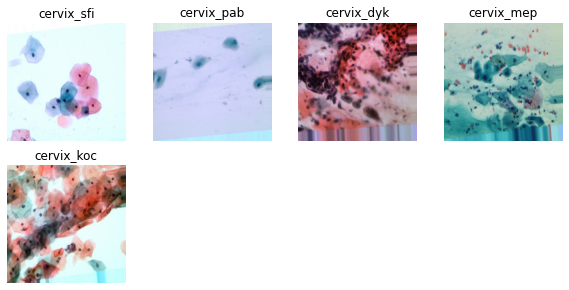

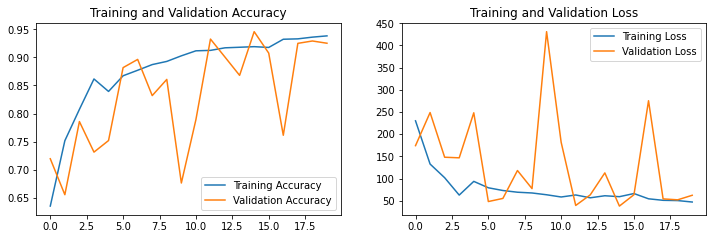

157/157 [==============================] - 26s 167ms/step - loss: 62.3115 - accuracy: 0.9252
Accuracy on the Test Set = 92.52 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 0 0 ... 0 4 4]


<Figure size 432x288 with 0 Axes>

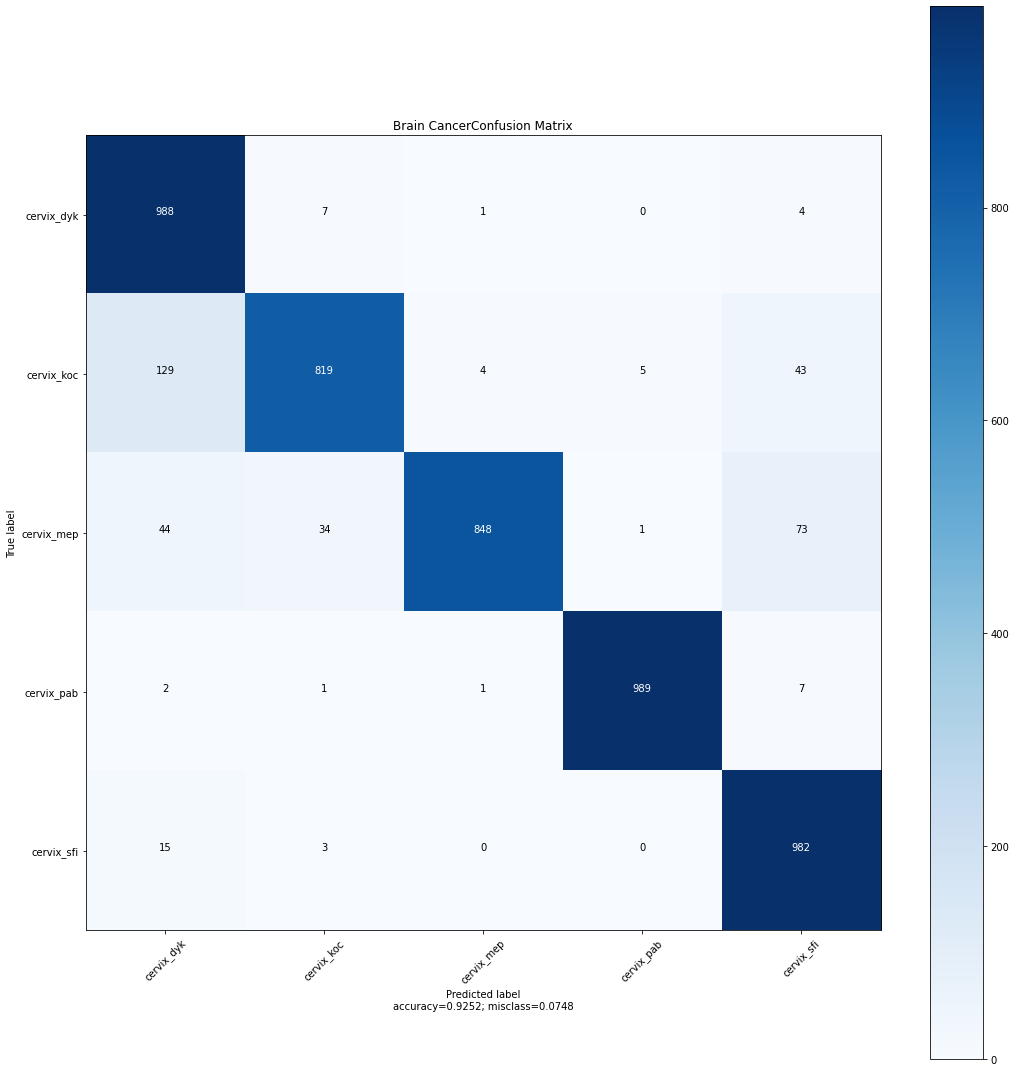

<Figure size 432x288 with 0 Axes>

In [12]:
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
625/625 [==============================] - 141s 226ms/step - loss: 112.4929 - accuracy: 0.8426 - val_loss: 83.1376 - val_accuracy: 0.8626

Epoch 00002: val_loss improved from 91.95786 to 83.13763, saving model to Brain CancerResNet50V2.h5
Epoch 3/20
625/625 [==============================] - 139s 223ms/step - loss: 123.6110 - accuracy: 0.8532 - val_loss: 87.9667 - val_accuracy: 0.8764

Epoch 00003: val_loss did not improve from 83.13763
Epoch 4/20
625/625 [==============================] - 140s 224ms/step - loss: 91.9946 - accuracy: 0.8769 - val_loss: 67.1413 - val_accuracy: 0.8994

Epoch 00004: val_loss improved from 83.13763 to 67.14127, saving model to Brain CancerResNet50V2.h5
Epoch 5/20
625/625 [==============================] - 142s 227ms/step - loss: 84.7061 - accuracy: 0.8885 - val_loss: 50.4061 - val_accuracy: 0.9156

Epoch 00005: val_loss improved from 67.14127 to 50.40610, saving model to Brain CancerResNet50V2.h5
Epoch 6/20
625/625 [==============================

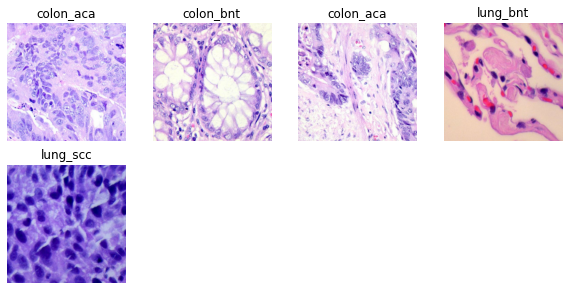

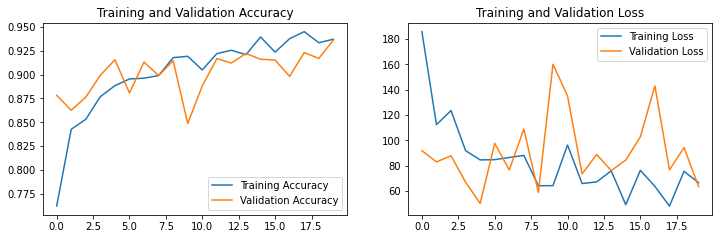

157/157 [==============================] - 31s 196ms/step - loss: 63.7272 - accuracy: 0.9362
Accuracy on the Test Set = 93.62 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

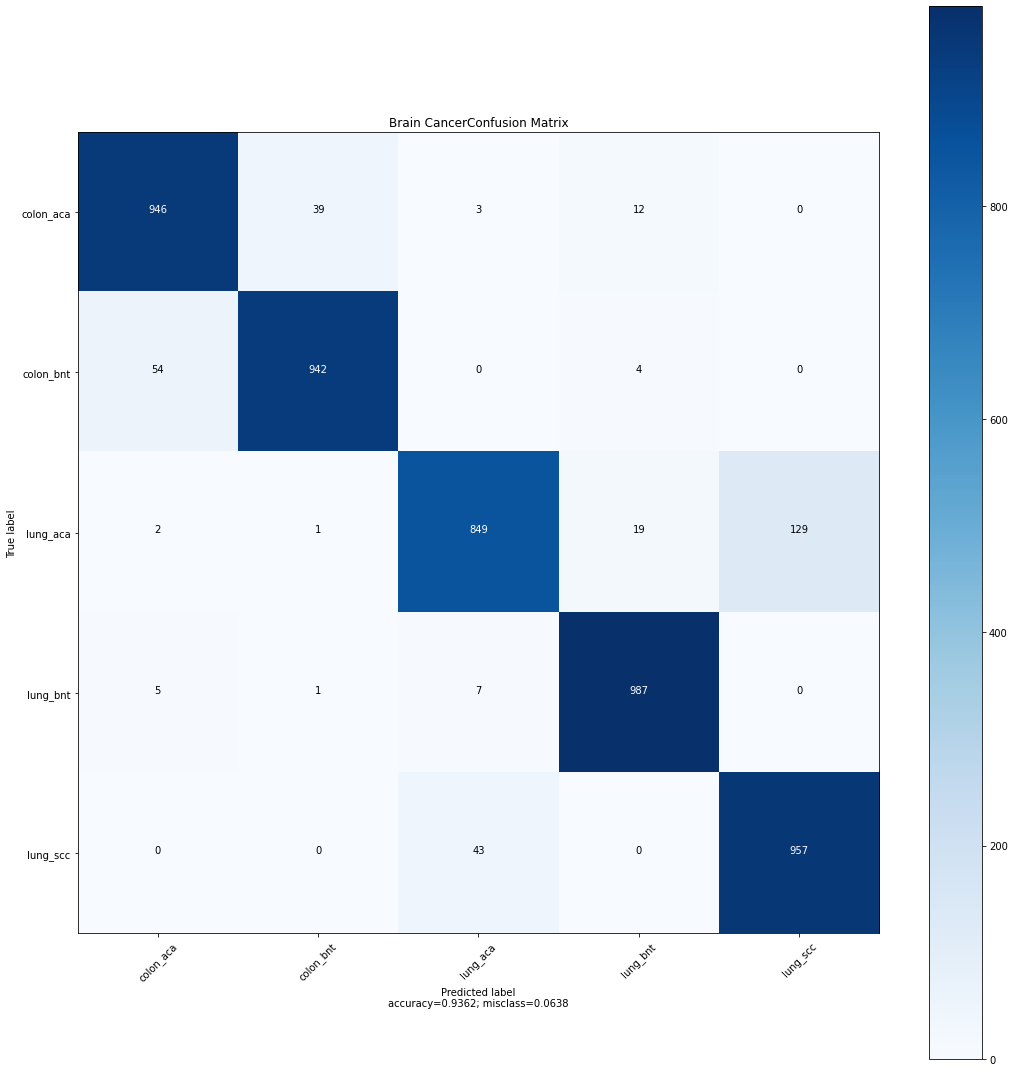

<Figure size 432x288 with 0 Axes>

In [13]:
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 8002 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_________________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
251/251 [==============================] - 58s 231ms/step - loss: 98.3736 - accuracy: 0.7108 - val_loss: 78.9921 - val_accuracy: 0.7390

Epoch 00002: val_loss did not improve from 49.00637
Epoch 3/20
251/251 [==============================] - 58s 231ms/step - loss: 109.5671 - accuracy: 0.7369 - val_loss: 47.8448 - val_accuracy: 0.7745

Epoch 00003: val_loss improved from 49.00637 to 47.84480, saving model to Brain CancerResNet50V2.h5
Epoch 4/20
251/251 [==============================] - 53s 212ms/step - loss: 68.8636 - accuracy: 0.7759 - val_loss: 139.6542 - val_accuracy: 0.6825

Epoch 00004: val_loss did not improve from 47.84480
Epoch 5/20
251/251 [==============================] - 53s 212ms/step - loss: 51.6148 - accuracy: 0.8158 - val_loss: 65.4613 - val_accuracy: 0.7915

Epoch 00005: val_loss did not improve from 47.84480
Epoch 6/20
251/251 [==============================] - 59s 234ms/step - loss: 59.7934 - accuracy: 0.8128 - val_loss: 56.8798 - val_accuracy: 0.7970

Ep

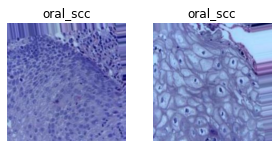

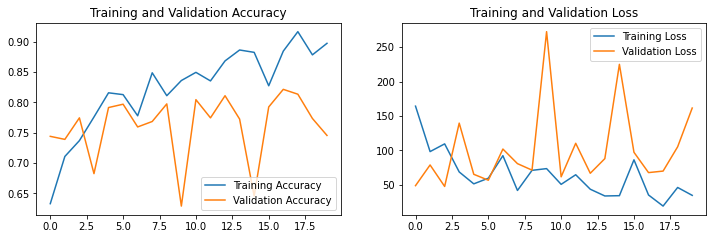

63/63 [==============================] - 11s 170ms/step - loss: 161.5300 - accuracy: 0.7455
Accuracy on the Test Set = 74.55 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 1 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

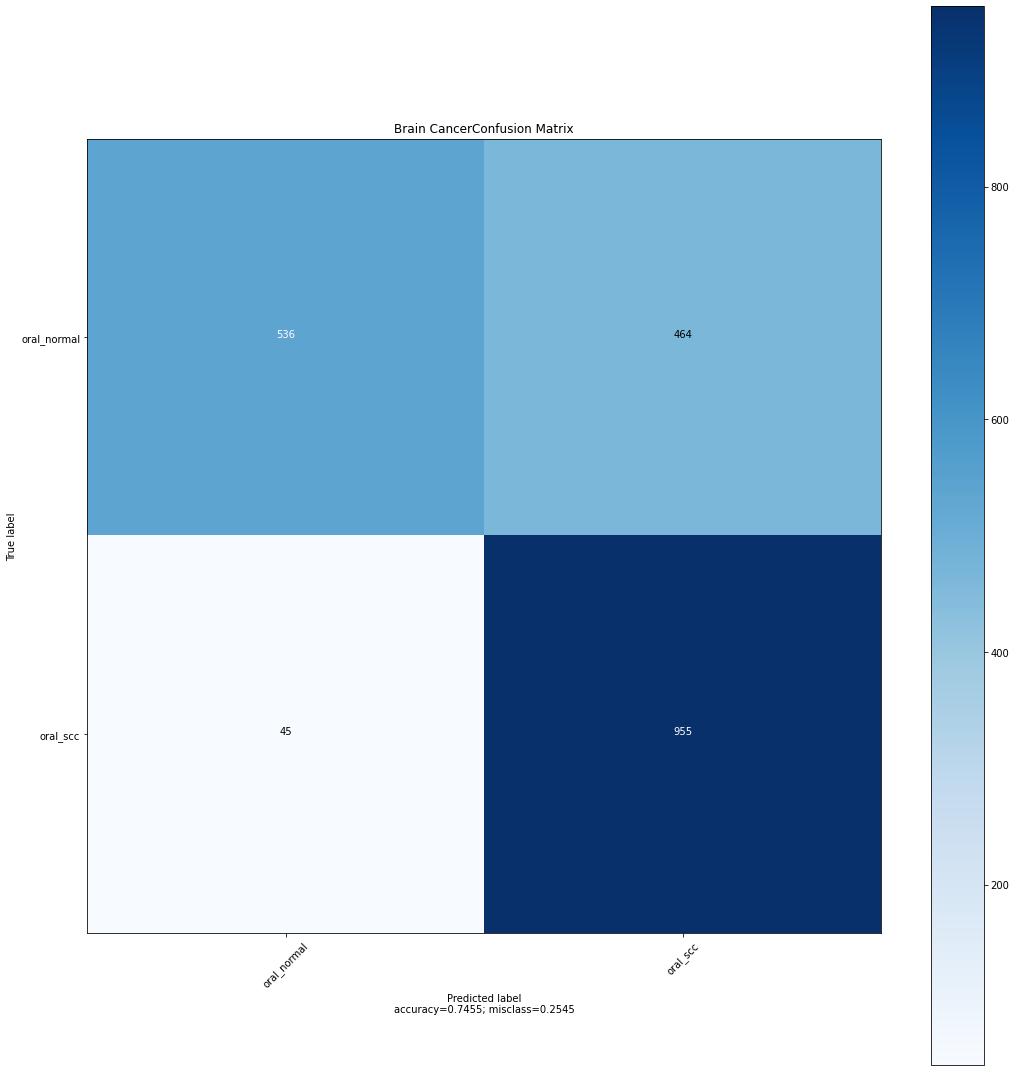

<Figure size 432x288 with 0 Axes>

In [14]:
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 16000 images belonging to 4 classes.

For Val :  Found 4000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
500/500 [==============================] - 106s 212ms/step - loss: 108.1843 - accuracy: 0.7376 - val_loss: 136.8958 - val_accuracy: 0.7297

Epoch 00002: val_loss did not improve from 43.41328
Epoch 3/20
500/500 [==============================] - 101s 203ms/step - loss: 103.0694 - accuracy: 0.7904 - val_loss: 223.4960 - val_accuracy: 0.6655

Epoch 00003: val_loss did not improve from 43.41328
Epoch 4/20
500/500 [==============================] - 99s 199ms/step - loss: 80.3233 - accuracy: 0.8166 - val_loss: 177.6068 - val_accuracy: 0.6470

Epoch 00004: val_loss did not improve from 43.41328
Epoch 5/20
500/500 [==============================] - 99s 198ms/step - loss: 73.6306 - accuracy: 0.8383 - val_loss: 81.7516 - val_accuracy: 0.8083

Epoch 00005: val_loss did not improve from 43.41328
Epoch 6/20
500/500 [==============================] - 101s 202ms/step - loss: 83.2931 - accuracy: 0.8370 - val_loss: 156.0676 - val_accuracy: 0.7857

Epoch 00006: val_loss did not improve from 

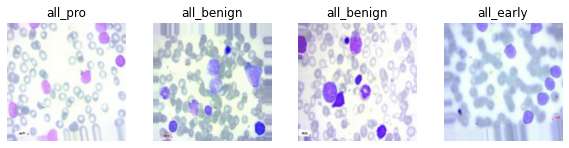

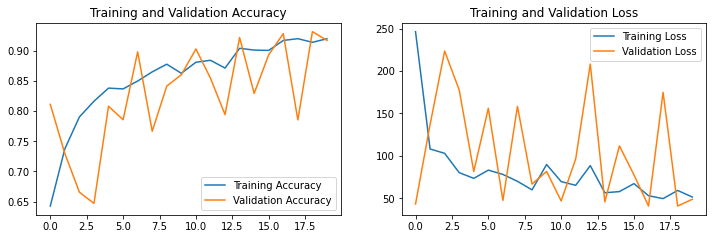

125/125 [==============================] - 27s 218ms/step - loss: 48.9555 - accuracy: 0.9175
Accuracy on the Test Set = 91.75 %
Model Saved!
True :  [0 0 0 ... 3 3 3]
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 432x288 with 0 Axes>

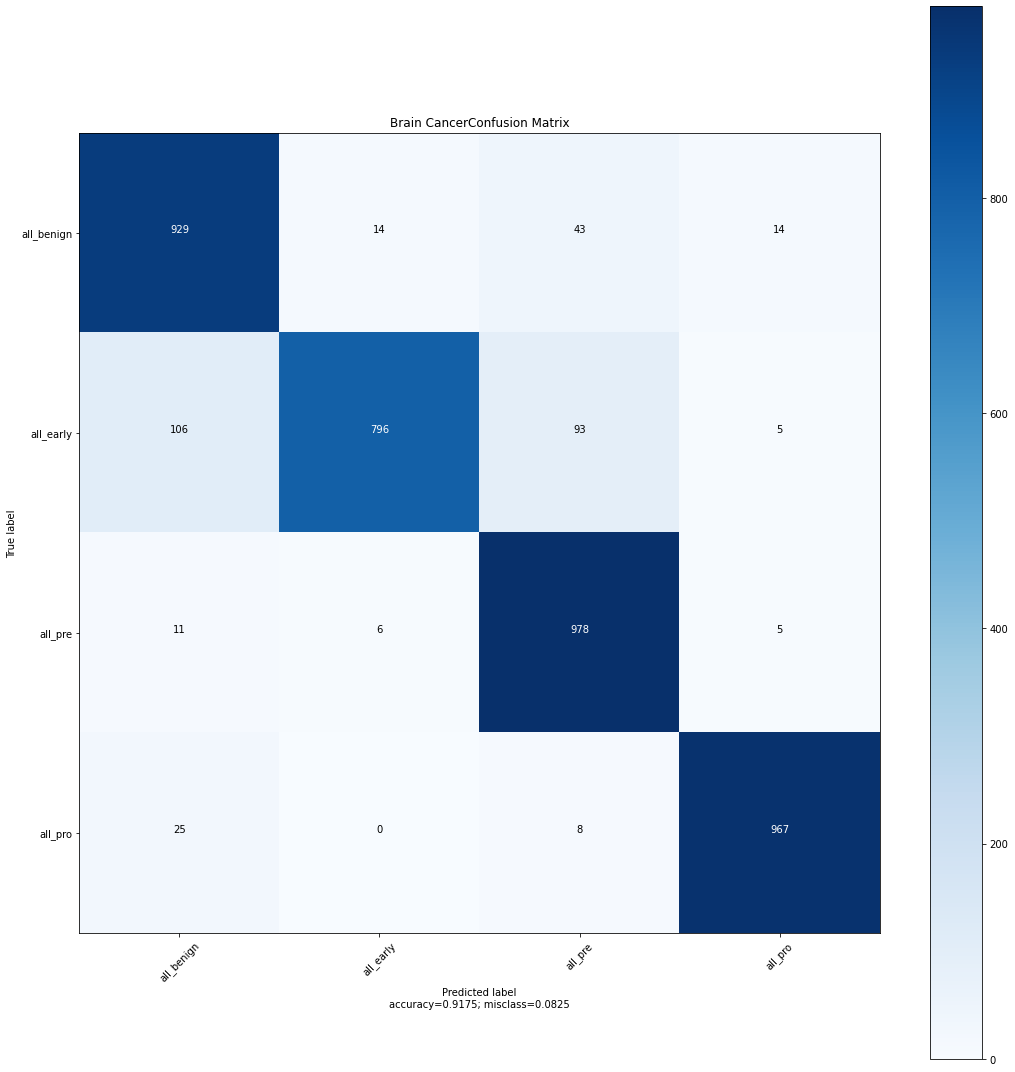

<Figure size 432x288 with 0 Axes>

In [15]:
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
___________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
250/250 [==============================] - 58s 232ms/step - loss: 1.7207 - accuracy: 0.9869 - val_loss: 62.0055 - val_accuracy: 0.8195

Epoch 00002: val_loss improved from 96.89735 to 62.00548, saving model to Kidney Cancer ResNet50V2.h5
Epoch 3/20
250/250 [==============================] - 49s 196ms/step - loss: 3.4390 - accuracy: 0.9870 - val_loss: 138.7441 - val_accuracy: 0.8110

Epoch 00003: val_loss did not improve from 62.00548
Epoch 4/20
250/250 [==============================] - 48s 192ms/step - loss: 2.2300 - accuracy: 0.9887 - val_loss: 61.7755 - val_accuracy: 0.8535

Epoch 00004: val_loss improved from 62.00548 to 61.77553, saving model to Kidney Cancer ResNet50V2.h5
Epoch 5/20
250/250 [==============================] - 57s 227ms/step - loss: 0.7680 - accuracy: 0.9964 - val_loss: 115.2915 - val_accuracy: 0.8520

Epoch 00005: val_loss did not improve from 61.77553
Epoch 6/20
250/250 [==============================] - 49s 196ms/step - loss: 2.8208 - accuracy: 0.9900

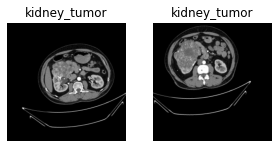

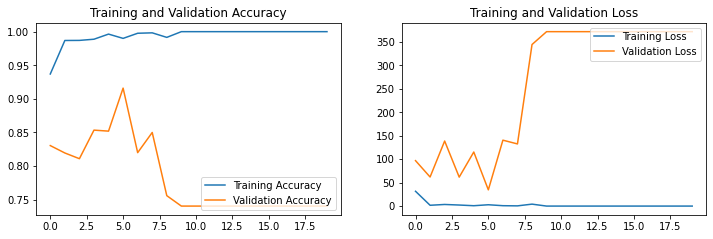

63/63 [==============================] - 16s 243ms/step - loss: 371.9822 - accuracy: 0.7405
Accuracy on the Test Set = 74.05 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

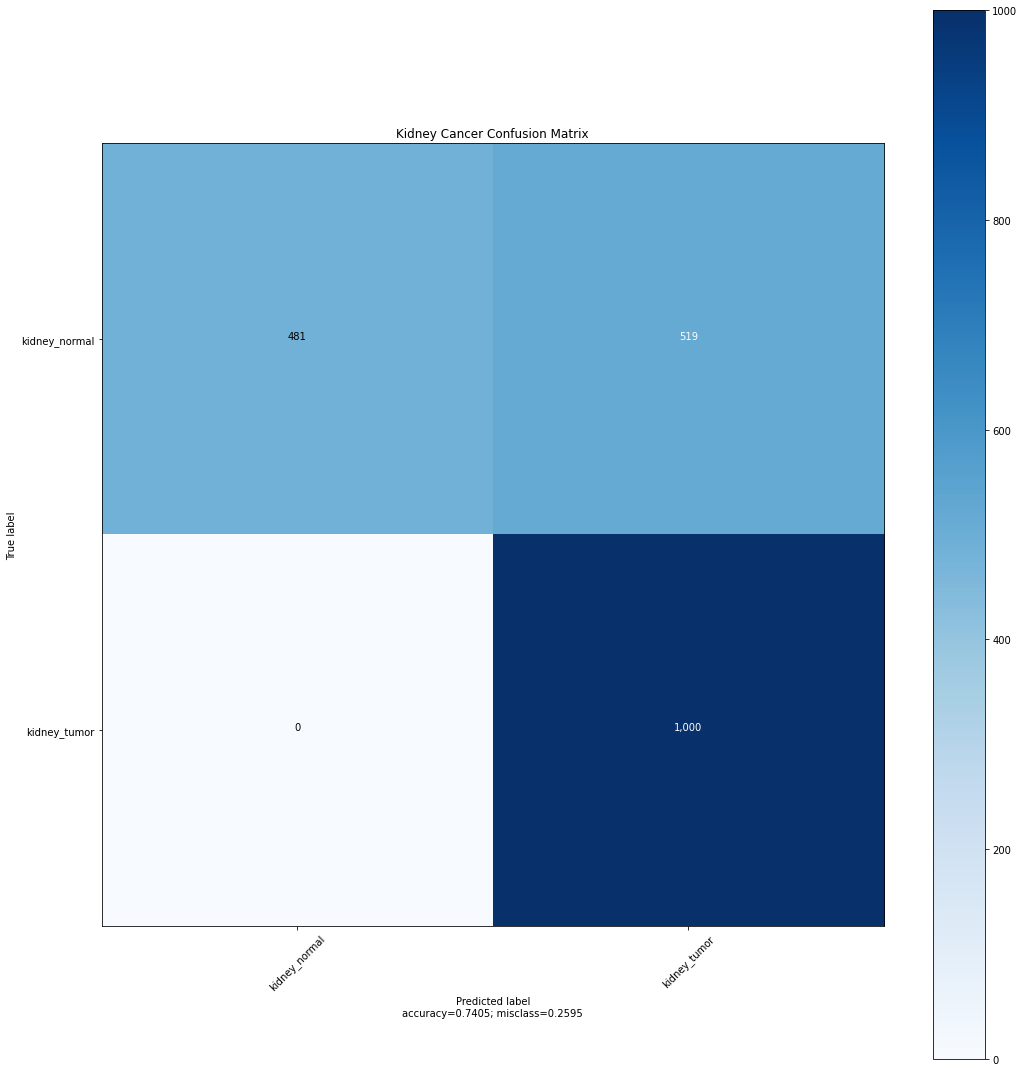

<Figure size 432x288 with 0 Axes>

In [16]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_______________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
250/250 [==============================] - 79s 315ms/step - loss: 82.1923 - accuracy: 0.8320 - val_loss: 145.4911 - val_accuracy: 0.7620

Epoch 00002: val_loss did not improve from 35.67601
Epoch 3/20
250/250 [==============================] - 88s 352ms/step - loss: 54.7666 - accuracy: 0.8780 - val_loss: 42.1939 - val_accuracy: 0.8575

Epoch 00003: val_loss did not improve from 35.67601
Epoch 4/20
250/250 [==============================] - 81s 322ms/step - loss: 72.5565 - accuracy: 0.8610 - val_loss: 36.6712 - val_accuracy: 0.9025

Epoch 00004: val_loss did not improve from 35.67601
Epoch 5/20
250/250 [==============================] - 86s 344ms/step - loss: 42.6890 - accuracy: 0.8979 - val_loss: 34.3423 - val_accuracy: 0.9155

Epoch 00005: val_loss improved from 35.67601 to 34.34227, saving model to Breast Cancer ResNet50V2.h5
Epoch 6/20
250/250 [==============================] - 87s 348ms/step - loss: 50.9881 - accuracy: 0.8978 - val_loss: 61.7736 - val_accuracy: 0.8860

E

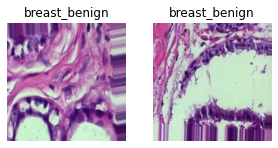

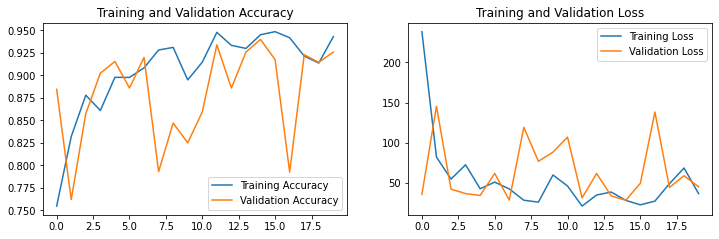

63/63 [==============================] - 16s 258ms/step - loss: 45.0666 - accuracy: 0.9260
Accuracy on the Test Set = 92.60 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

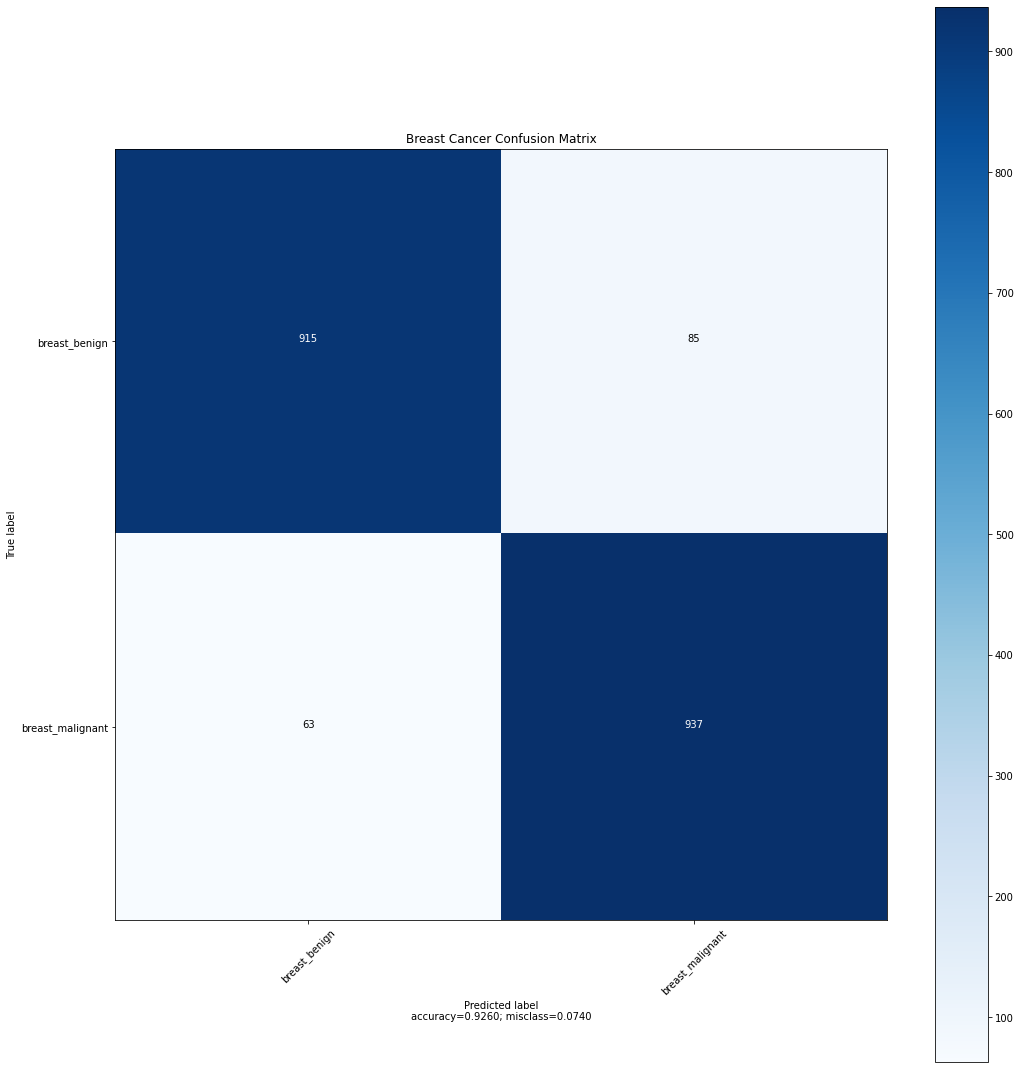

<Figure size 432x288 with 0 Axes>

In [17]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_____________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
375/375 [==============================] - 101s 268ms/step - loss: 77.9385 - accuracy: 0.6774 - val_loss: 54.4298 - val_accuracy: 0.7283

Epoch 00002: val_loss did not improve from 49.06029
Epoch 3/20
375/375 [==============================] - 90s 241ms/step - loss: 65.8947 - accuracy: 0.7227 - val_loss: 35.4334 - val_accuracy: 0.7763

Epoch 00003: val_loss improved from 49.06029 to 35.43338, saving model to Lymphoma ResNet50V2.h5
Epoch 4/20
375/375 [==============================] - 90s 240ms/step - loss: 49.1873 - accuracy: 0.7742 - val_loss: 29.4353 - val_accuracy: 0.8240

Epoch 00004: val_loss improved from 35.43338 to 29.43526, saving model to Lymphoma ResNet50V2.h5
Epoch 5/20
375/375 [==============================] - 90s 240ms/step - loss: 51.7188 - accuracy: 0.7862 - val_loss: 23.3100 - val_accuracy: 0.8400

Epoch 00005: val_loss improved from 29.43526 to 23.30998, saving model to Lymphoma ResNet50V2.h5
Epoch 6/20
375/375 [==============================] - 90s 241ms/

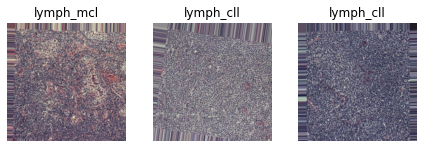

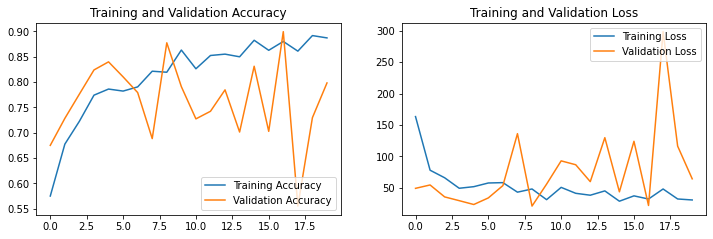

94/94 [==============================] - 19s 198ms/step - loss: 64.1990 - accuracy: 0.7983
Accuracy on the Test Set = 79.83 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 2 ... 2 1 2]


<Figure size 432x288 with 0 Axes>

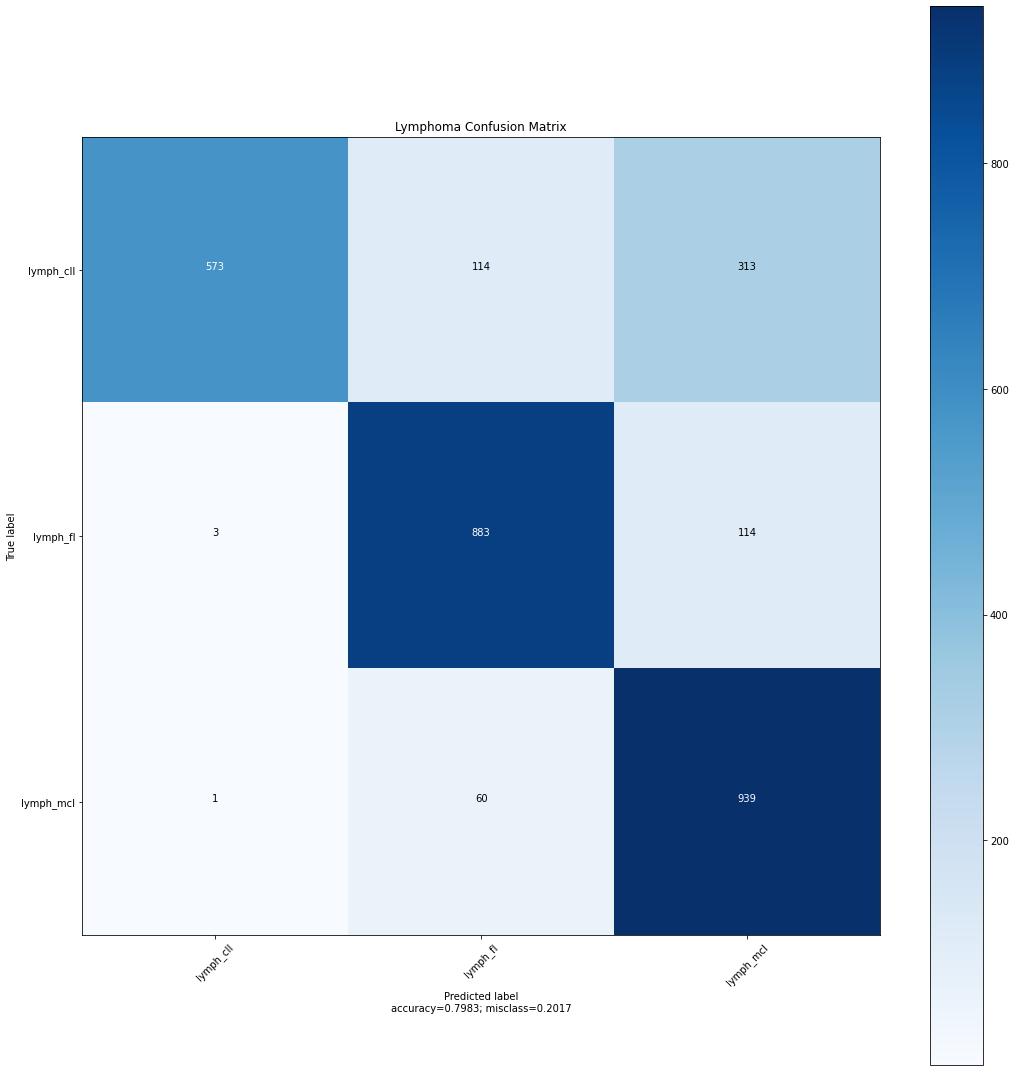

<Figure size 432x288 with 0 Axes>

In [18]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_____________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
375/375 [==============================] - 72s 192ms/step - loss: 38.9473 - accuracy: 0.8351 - val_loss: 40.3137 - val_accuracy: 0.8277

Epoch 00002: val_loss improved from 114.83066 to 40.31368, saving model to Brain Cancer ResNet50V2.h5
Epoch 3/20
375/375 [==============================] - 83s 222ms/step - loss: 33.9180 - accuracy: 0.8566 - val_loss: 35.7968 - val_accuracy: 0.8577

Epoch 00003: val_loss improved from 40.31368 to 35.79681, saving model to Brain Cancer ResNet50V2.h5
Epoch 4/20
375/375 [==============================] - 73s 194ms/step - loss: 37.0269 - accuracy: 0.8656 - val_loss: 56.4797 - val_accuracy: 0.8303

Epoch 00004: val_loss did not improve from 35.79681
Epoch 5/20
375/375 [==============================] - 72s 192ms/step - loss: 26.2417 - accuracy: 0.8948 - val_loss: 55.8361 - val_accuracy: 0.8430

Epoch 00005: val_loss did not improve from 35.79681
Epoch 6/20
375/375 [==============================] - 72s 193ms/step - loss: 23.6886 - accuracy: 0.90

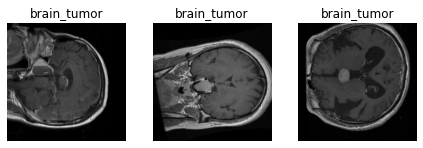

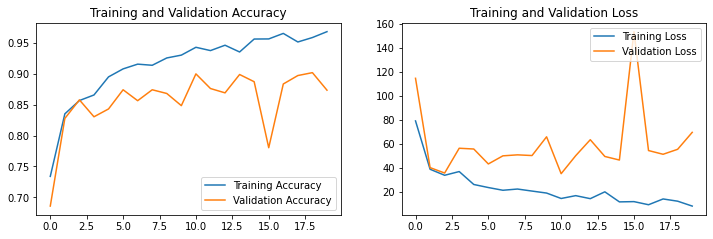

94/94 [==============================] - 14s 147ms/step - loss: 69.7318 - accuracy: 0.8733
Accuracy on the Test Set = 87.33 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 1]


<Figure size 432x288 with 0 Axes>

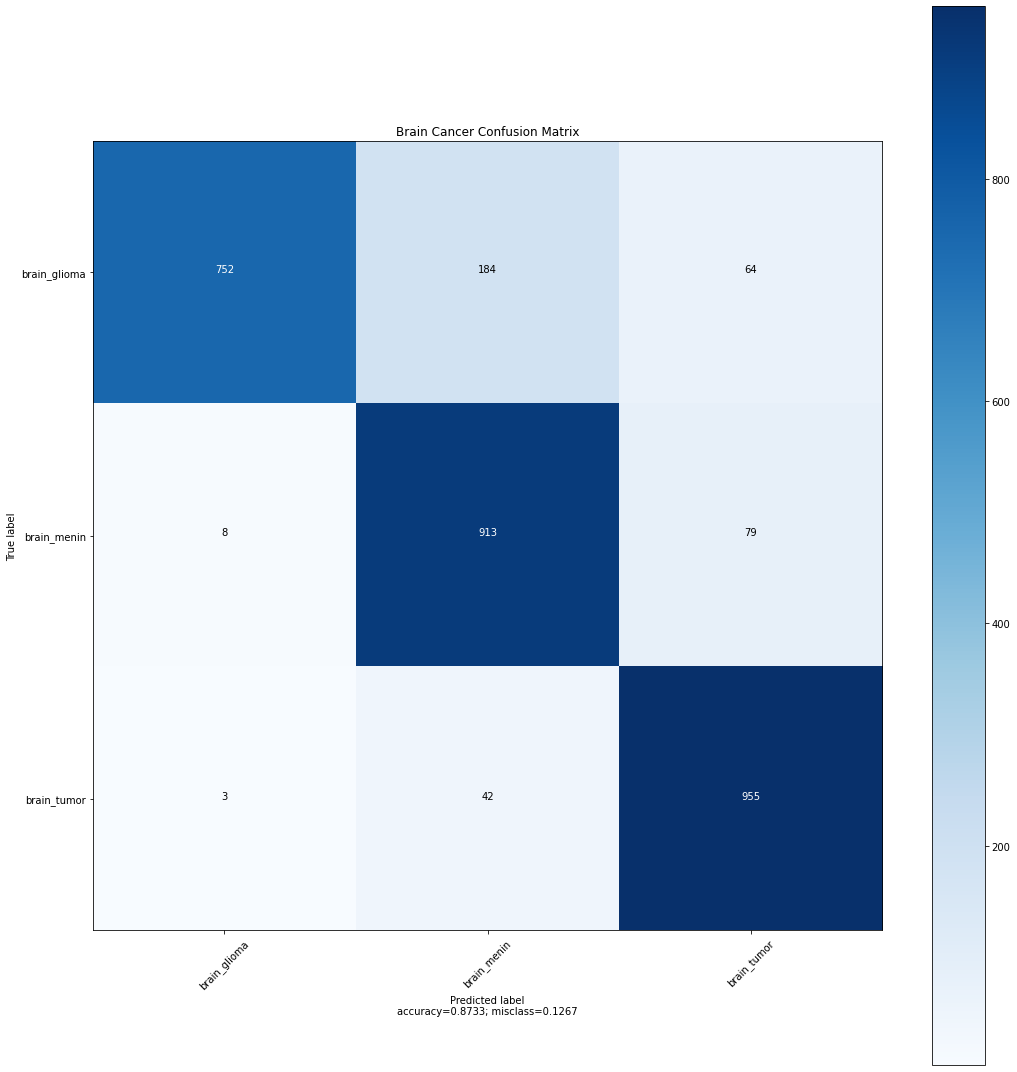

<Figure size 432x288 with 0 Axes>

In [19]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)